# Introduction to Tensorflow

## Using tensorflow as a numpy alternative
[see TF numpy](https://www.tensorflow.org/guide/tf_numpy)

TensorFlow implements a subset of the NumPy API, available as tf.experimental.numpy. This allows running NumPy code, accelerated by TensorFlow, while also allowing access to all of TensorFlow's APIs.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
import timeit
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disbale CUDA warnings

print("Using TensorFlow version {}".format(tf.__version__))

Using TensorFlow version 2.15.0


## TensorFlow NumPy ND array

An instance of `tf.experimental.numpy.ndarray`, called **ND Array**, represents a multidimensional dense array of a given `dtype` placed on a certain device. It is an alias to `tf.Tensor`. Check out the ND array class for useful methods like `ndarray.T`, `ndarray.reshape`, `ndarray.ravel` and others.

First create an ND array object, and then invoke different methods.

In [9]:
# Create an ND array and check out different attributes.
ones = tnp.ones([5, 3], dtype=tnp.float32)
print("Created ND array with shape = %s, rank = %s, "
      "dtype = %s on device = %s\n" % (
          ones.shape, ones.ndim, ones.dtype, ones.device))

# `ndarray` is just an alias to `tf.Tensor`.
print("Is `ones` an instance of tf.Tensor: %s\n" % isinstance(ones, tf.Tensor))

Created ND array with shape = (5, 3), rank = 2, dtype = <dtype: 'float32'> on device = /job:localhost/replica:0/task:0/device:CPU:0

Is `ones` an instance of tf.Tensor: True



In [14]:
ones.shape

TensorShape([5, 3])

In [15]:
ones

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)>

### Type promotion
> One special case of implicit type conversion is type promotion, where an object is automatically converted into another data type representing a superset of the original type

[source](https://en.wikipedia.org/wiki/Type_conversion#Type_promotion)

Tensorflow has no automatic type promotion,

numpy does:

In [19]:
np.promote_types(np.float32, np.float64)

dtype('float64')

In [20]:
np.promote_types(np.int32, np.float64)

dtype('float64')

In [26]:
np.promote_types(np.int32, np.float16)

dtype('float64')

In [28]:
np.promote_types(np.complex64, np.float128)

dtype('complex256')

In [33]:
# https://numpy.org/doc/stable/reference/arrays.dtypes.html#arrays-dtypes
np.promote_types(np.int8, np.datetime64)

TypeError: The DTypes <class 'numpy.dtype[int8]'> and <class 'numpy.dtype[datetime64]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

In tensorflow we have to set the desired behavior:

There are 4 options for type promotion in TensorFlow.

- By default, TensorFlow raises errors instead of promoting types for mixed type operations.
- Running `tf.numpy.experimental_enable_numpy_behavior()` switches TensorFlow to use `NumPy` type promotion rules (described below).
- After TensorFlow 2.15, there are two new options (refer to [TF NumPy Type Promotion](tf_numpy_type_promotion.ipynb) for details):
  - `tf.numpy.experimental_enable_numpy_behavior(dtype_conversion_mode="all")` uses Jax type promotion rules.
  - `tf.numpy.experimental_enable_numpy_behavior(dtype_conversion_mode="safe")` uses Jax type promotion rules, but disallows certain unsafe promotions.

In [37]:
tnp.experimental_enable_numpy_behavior(dtype_conversion_mode="all")

In [38]:
print("Type promotion for operations")
values = [tnp.asarray(1, dtype=d) for d in
          (tnp.int32, tnp.int64, tnp.float32, tnp.float64)]
for i, v1 in enumerate(values):
  for v2 in values[i + 1:]:
    print("%s + %s => %s" %
          (v1.dtype.name, v2.dtype.name, (v1 + v2).dtype.name))

Type promotion for operations
int32 + int64 => int64
int32 + float32 => float32
int32 + float64 => float64
int64 + float32 => float32
int64 + float64 => float64
float32 + float64 => float64


In [39]:
tnp.experimental_enable_numpy_behavior(dtype_conversion_mode="safe")
print("Type promotion for operations")
values = [tnp.asarray(1, dtype=d) for d in
          (tnp.int32, tnp.int64, tnp.float32, tnp.float64)]
for i, v1 in enumerate(values):
  for v2 in values[i + 1:]:
    print("%s + %s => %s" %
          (v1.dtype.name, v2.dtype.name, (v1 + v2).dtype.name))

Type promotion for operations
int32 + int64 => int64


TypeError: In promotion mode PromoMode.SAFE, implicit dtype promotion between (<dtype: 'int32'>, weak=False) and (<dtype: 'float32'>, weak=False) is disallowed. You need to explicitly specify the dtype in your op, or relax your dtype promotion rules (such as from SAFE mode to ALL mode).

In [40]:
print("Type inference during array creation")
print("tnp.asarray(1).dtype == tnp.%s" % tnp.asarray(1).dtype.name)
print("tnp.asarray(1.).dtype == tnp.%s\n" % tnp.asarray(1.).dtype.name)

Type inference during array creation
tnp.asarray(1).dtype == tnp.int32
tnp.asarray(1.).dtype == tnp.float32



When converting literals to ND array, NumPy prefers wide types like `tnp.int64` and `tnp.float64`. In contrast, `tf.convert_to_tensor` prefers `tf.int32` and `tf.float32` types for converting constants to `tf.Tensor`. TensorFlow NumPy APIs adhere to the NumPy behavior for integers. As for floats, the `prefer_float32` argument of `experimental_enable_numpy_behavior` lets you control whether to prefer `tf.float32` over `tf.float64` (default to `False`). For example:

In [41]:
tnp.experimental_enable_numpy_behavior(prefer_float32=True)
print("When prefer_float32 is True:")
print("tnp.asarray(1.).dtype == tnp.%s" % tnp.asarray(1.).dtype.name)
print("tnp.add(1., 2.).dtype == tnp.%s" % tnp.add(1., 2.).dtype.name)

tnp.experimental_enable_numpy_behavior(prefer_float32=False)
print("When prefer_float32 is False:")
print("tnp.asarray(1.).dtype == tnp.%s" % tnp.asarray(1.).dtype.name)
print("tnp.add(1., 2.).dtype == tnp.%s" % tnp.add(1., 2.).dtype.name)

When prefer_float32 is True:
tnp.asarray(1.).dtype == tnp.float32
tnp.add(1., 2.).dtype == tnp.float32
When prefer_float32 is False:
tnp.asarray(1.).dtype == tnp.float64
tnp.add(1., 2.).dtype == tnp.float64


### Broadcasting

>The term broadcasting describes how NumPy treats arrays with different shapes during arithmetic operations. Subject to certain constraints, the smaller array is “broadcast” across the larger array so that they have compatible shapes.

Similar to TensorFlow, NumPy defines rich semantics for "broadcasting" values.
Check out the [NumPy broadcasting guide](https://numpy.org/doc/1.16/user/basics.broadcasting.html) for more information and compare this with [TensorFlow broadcasting semantics](https://www.tensorflow.org/guide/tensor#broadcasting).

In [56]:
a = np.array([1.0, 2.0, 3.0])
b = np.array([2.0, 2.0, 2.0])
a * b

array([2., 4., 6.])

In [57]:
a = np.array([1.0, 2.0, 3.0])
b = 2.0
a * b

array([2., 4., 6.])

In [58]:
a = np.array([[ 0.0,  0.0,  0.0],
              [10.0, 10.0, 10.0],
              [20.0, 20.0, 20.0],
              [30.0, 30.0, 30.0]])
b = np.array([1.0, 2.0, 3.0])
a + b

array([[ 1.,  2.,  3.],
       [11., 12., 13.],
       [21., 22., 23.],
       [31., 32., 33.]])

In [59]:
b = np.array([1.0, 2.0, 3.0, 4.0])
a + b

ValueError: operands could not be broadcast together with shapes (4,3) (4,) 

In [62]:
x = np.ones([2, 3])
y = np.ones([3])
z = np.ones([1, 2, 1])
print("Broadcasting shapes %s, %s and %s gives shape %s" % (
    x.shape, y.shape, z.shape, (x + y + z).shape))

Broadcasting shapes (2, 3), (3,) and (1, 2, 1) gives shape (1, 2, 3)


In [60]:
a = tnp.array([[ 0.0,  0.0,  0.0],
              [10.0, 10.0, 10.0],
              [20.0, 20.0, 20.0],
              [30.0, 30.0, 30.0]])
b = tnp.array([1.0, 2.0, 3.0])
a + b

<tf.Tensor: shape=(4, 3), dtype=float64, numpy=
array([[ 1.,  2.,  3.],
       [11., 12., 13.],
       [21., 22., 23.],
       [31., 32., 33.]])>

In [61]:
b = tnp.array([1.0, 2.0, 3.0, 4.0])
a + b

InvalidArgumentError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [4,3] vs. [4] [Op:AddV2] name: 

In [54]:
x = tnp.ones([2, 3])
y = tnp.ones([3])
z = tnp.ones([1, 2, 1])
print("Broadcasting shapes %s, %s and %s gives shape %s" % (
    x.shape, y.shape, z.shape, (x + y + z).shape))

Broadcasting shapes (2, 3), (3,) and (1, 2, 1) gives shape (1, 2, 3)


### Indexing

NumPy defines very sophisticated indexing rules. See the [NumPy Indexing guide](https://numpy.org/doc/1.16/reference/arrays.indexing.html). Note the use of ND arrays as indices below.

In [65]:
x = tnp.arange(24).reshape(2, 3, 4)
x

<tf.Tensor: shape=(2, 3, 4), dtype=int64, numpy=
array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])>

In [68]:
print("Basic indexing")
print(x[1, tnp.newaxis, 1:3, ...])

Basic indexing
tf.Tensor(
[[[16 17 18 19]
  [20 21 22 23]]], shape=(1, 2, 4), dtype=int64)


In [69]:
print("Boolean indexing")
print(x[:, (True, False, True)])

Boolean indexing
tf.Tensor(
[[[ 0  1  2  3]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [20 21 22 23]]], shape=(2, 2, 4), dtype=int64)


In [70]:
print("Advanced indexing")
print(x[1, (0, 0, 1), tnp.asarray([0, 1, 1])])

Advanced indexing
tf.Tensor([12 13 17], shape=(3,), dtype=int64)


## Benchmark

In [42]:
def benchmark(f, inputs, number=30, force_gpu_sync=False):
  """Utility to benchmark `f` on each value in `inputs`."""
  times = []
  for inp in inputs:
    def _g():
      if force_gpu_sync:
        one = tnp.asarray(1)
      f(inp)
      if force_gpu_sync:
        with tf.device("CPU:0"):
          tnp.copy(one)  # Force a sync for GPU case

    _g()  # warmup
    t = timeit.timeit(_g, number=number)
    times.append(t * 1000. / number)
  return times


def plot(np_times, tnp_times, compiled_tnp_times, has_gpu, tnp_times_gpu):
  """Plot the different runtimes."""
  plt.xlabel("size")
  plt.ylabel("time (ms)")
  plt.title("Sigmoid benchmark: TF NumPy vs NumPy")
  plt.plot(sizes, np_times, label="NumPy")
  plt.plot(sizes, tnp_times, label="TF NumPy (CPU)")
  plt.plot(sizes, compiled_tnp_times, label="Compiled TF NumPy (CPU)")
  if has_gpu:
    plt.plot(sizes, tnp_times_gpu, label="TF NumPy (GPU)")
  plt.legend()

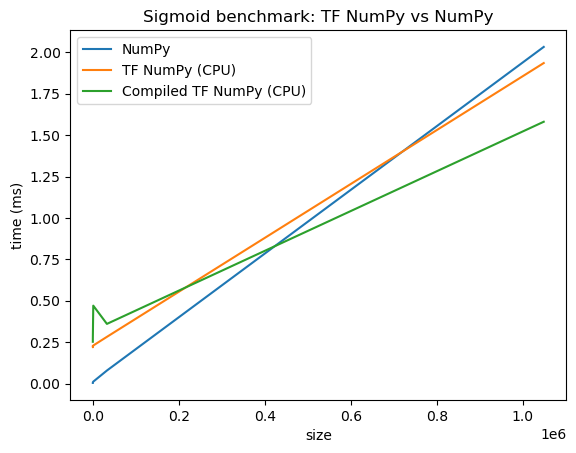

In [52]:
# Define a simple implementation of `sigmoid`, and benchmark it using
# NumPy and TensorFlow NumPy for different input sizes.

def np_sigmoid(y):
  return 1. / (1. + np.exp(-y))

def tnp_sigmoid(y):
  return 1. / (1. + tnp.exp(-y))

@tf.function
def compiled_tnp_sigmoid(y):
  return tnp_sigmoid(y)

sizes = (2 ** 0, 2 ** 5, 2 ** 10, 2 ** 15, 2 ** 20) #, 2 ** 25)
np_inputs = [np.random.randn(size).astype(np.float32) for size in sizes]
np_times = benchmark(np_sigmoid, np_inputs)

with tf.device("/device:CPU:0"):
  tnp_inputs = [tnp.random.randn(size).astype(np.float32) for size in sizes]
  tnp_times = benchmark(tnp_sigmoid, tnp_inputs)
  compiled_tnp_times = benchmark(compiled_tnp_sigmoid, tnp_inputs)

has_gpu = len(tf.config.list_logical_devices("GPU"))
if has_gpu:
  with tf.device("/device:GPU:0"):
    tnp_inputs = [tnp.random.randn(size).astype(np.float32) for size in sizes]
    tnp_times_gpu = benchmark(compiled_tnp_sigmoid, tnp_inputs, 100, True)
else:
  tnp_times_gpu = None
plot(np_times, tnp_times, compiled_tnp_times, has_gpu, tnp_times_gpu)